# CS 722 HW4 - Report
## _Dániel B. Papp_

## Using Sklearn

#### Importing the libraries and the dataset

In [859]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
#warnings.filterwarnings("ignore")

df = pd.read_csv('./data.txt', sep=" ", header=None, names=['x', 'y'])

#### Initial data visualization

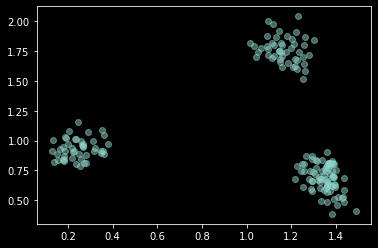

In [860]:
plt.scatter(x=df['x'], y=df['y'], alpha=0.5)

--------------------------------------------------
Iteration:  1
Cluster count:  2
SSE:  38.178802426511545
--------------------------------------------------


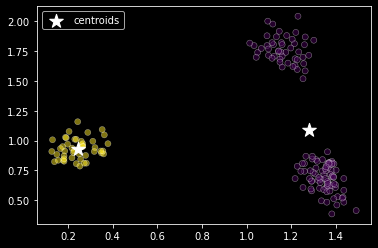

--------------------------------------------------
Iteration:  2
Cluster count:  3
SSE:  2.60399663544384
--------------------------------------------------


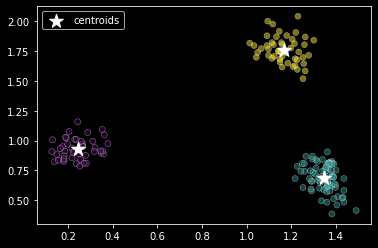

--------------------------------------------------
Iteration:  3
Cluster count:  4
SSE:  1.8879858148771735
--------------------------------------------------


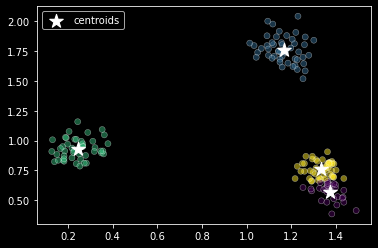

--------------------------------------------------
Iteration:  4
Cluster count:  5
SSE:  1.5113206634064227
--------------------------------------------------


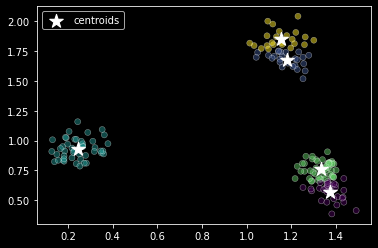

--------------------------------------------------
Iteration:  5
Cluster count:  6
SSE:  1.2834275084219695
--------------------------------------------------


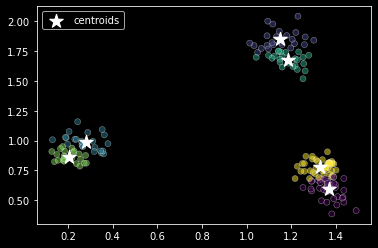

--------------------------------------------------
Iteration:  6
Cluster count:  7
SSE:  1.055891085492233
--------------------------------------------------


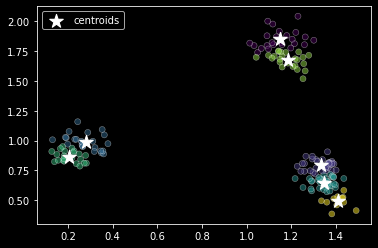

--------------------------------------------------
Iteration:  7
Cluster count:  8
SSE:  0.8985547132414987
--------------------------------------------------


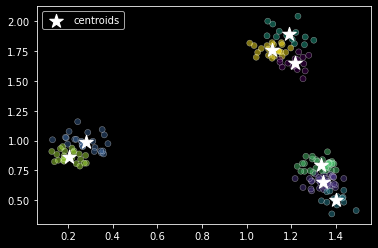

--------------------------------------------------
Iteration:  8
Cluster count:  9
SSE:  0.8124905003742229
--------------------------------------------------


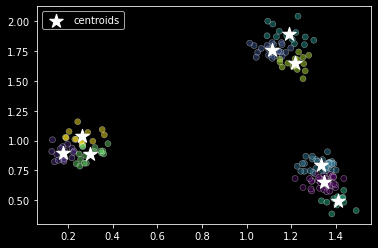

--------------------------------------------------
Iteration:  9
Cluster count:  10
SSE:  0.7301003173089191
--------------------------------------------------


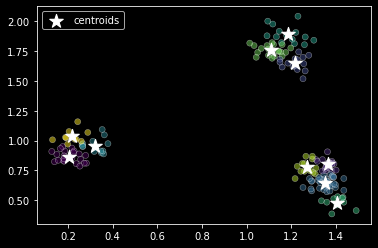

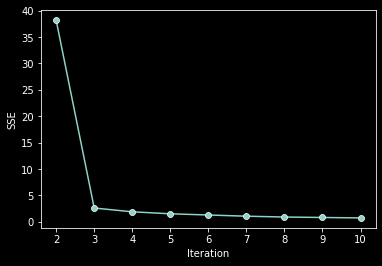

In [861]:
k_arr = np.arange(2, 11)
sse = []
for k in k_arr:
    km = KMeans(n_clusters=k, algorithm='elkan')
    y_pred = km.fit_predict(df[['x', 'y']])
    df['cluster'] = y_pred
    sse.append(km.inertia_)
    sns.scatterplot(x=df['x'], y=df['y'], c=df['cluster'], alpha=0.5)
    sns.scatterplot(x=km.cluster_centers_[:,0], y=km.cluster_centers_[:,1], marker='*', s=200, color='white', label='centroids')
    print(50*'-')
    print('Iteration: ', k - 1)
    print('Cluster count: ', k)
    print('SSE: ', sse[k-2])
    print(50*'-')
    plt.xlabel(None)
    plt.ylabel(None)   
    plt.show()

sns.lineplot(x=k_arr, y=sse, marker='o')
plt.xlabel('Iteration')
plt.ylabel('SSE')
plt.savefig(f'./img/sse.png')
plt.show()

## Numpy Method

In [870]:
data = np.loadtxt('./data.txt', delimiter=' ')
N = len(data)
K = 3
initialPoints = data[np.random.choice(N, K, replace=False)]

dist = np.zeros((N, K))
for i in range(K):
    dist[:,i] = ((data-initialPoints[i])**2).sum(axis=1)**0.5

In [874]:
from scipy.spatial.distance import cdist
np.random.seed(2418678412)
def kMeans(frame = data, k = K, n = N):
    fig, axs = plt.subplots(1, 2, figsize=(15, 7))
    closest = np.zeros(N).astype(int)
    cents = frame[np.random.choice(N, k, replace=False)]
    dist = np.zeros((N, k))
    sse = []

    for iteration in range(n):
        for j in range(k):
            dist[:,j] = ((frame-cents[j])**2).sum(axis=1)**0.5
            sse.append(np.sum(np.square(np.subtract(frame, cents[j]))))

        closest = np.argmin(dist, axis=1)
        for x in range(k):
            old_cents = cents
            cents[x, :] = frame[closest == x].mean(axis=0)
            if np.all(old_cents == cents):
                break

        sns.scatterplot(x=frame[:,0], y=frame[:,1], c=closest, alpha=0.5, ax=axs[0])
        sns.scatterplot(cents[:,0], cents[:,1], marker='*', s=200, color='white', label='centroids', ax=axs[0])
        sns.lineplot(x=range(len(sse)), y=sse, marker='o', ax=axs[1], label='SSE')
        plt.show()
        
    return closest, cents, sse

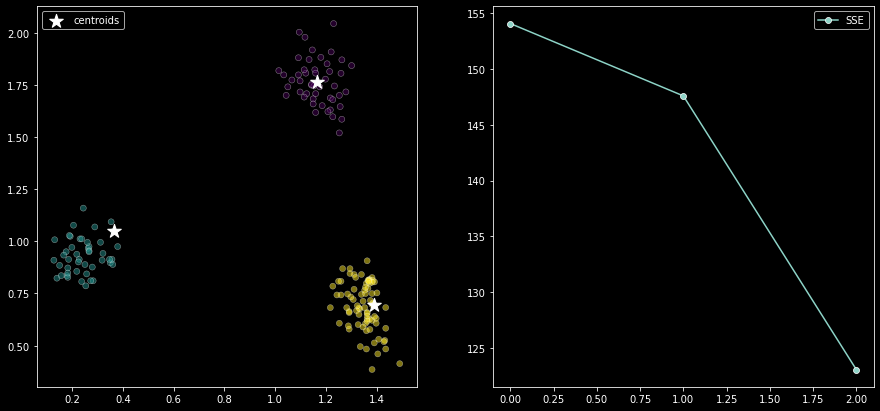

In [875]:
labels, centroids, sse = kMeans(data, 3, 100)

In [865]:
from numpy.linalg import norm
import csv

class Kmeans:
    def __init__(self, k, max_iterations=100, log=False):
        self.k = k
        self.max_iterations = max_iterations
        self.sse = []
        self.file = open('report.csv', 'a')
        self.save = csv.writer(self.file)
        self.log = log

    def initialize_centroids(self, X):
        np.random.RandomState(123)
        random_idx = np.random.permutation(X.shape[0])
        centroids = X[random_idx[:self.k]]
        return centroids

    def compute_centroids(self, X, labels):
        # initializing / resetting centroid values
        centroids = np.zeros((self.k, X.shape[1]))
        # getting the mean of each data points assigned to the cluster
        for k in range(self.k):
            centroids[k, :] = np.mean(X[labels == k, :], axis=0)
        return centroids

    def compute_distance(self, X, centroids):
        distance = np.zeros((X.shape[0], self.k))
        for k in range(self.k):
            row_norm = norm(X - centroids[k, :], axis=1)
            distance[:, k] = np.square(row_norm)
        return distance

    # simple helper function to find the smallest num in distance list input
    def find_closest_cluster(self, distance):
        return np.argmin(distance, axis=1)

    def compute_sse(self, X, labels, centroids):
        distance = np.zeros(X.shape[0])
        # getting the normalized distance of each data point in the cluster from the centroid
        for k in range(self.k):
            distance[labels == k] = norm(X[labels == k] - centroids[k], axis=1)
        score = np.sum(np.square(distance))
        self.sse.append(score)
        return score
    
    def fit(self, X):
        # place centroids in random locations
        self.centroids = self.initialize_centroids(X)
        for i in range(self.max_iterations):
            # keeping track of tail centroid (linked list way)
            old_centroids = self.centroids
            distance = self.compute_distance(X, old_centroids)
            self.labels = self.find_closest_cluster(distance)
            self.centroids = self.compute_centroids(X, self.labels)
            # cannot make a better adjustment so break
            if np.all(old_centroids == self.centroids):
                break
            # record SSE
            self.error = self.compute_sse(X, self.labels, self.centroids)
            # print report to console
            self.report(cent=self.centroids, error=self.error, iter=i)
            if self.log:
                self.plot(X)
        # this line makes sure that we are getting some sort of output even if we do not want it after every iteration
        # if logging is enabled, we create a plot after each iter, if it's False we create the plot after each successful clustering
        if self.log == False:
            self.plot(X)
        self.cleanup()
    
    def predict(self, X):
        distance = self.compute_distance(X, self.centroids)
        return self.find_closest_cluster(distance)

    # create plot for base data and centroids 2D scatterplot, and SSE convergence curve
    def plot(self, X):
        fig, axs = plt.subplots(1, 2, figsize=(12, 6))
        sns.scatterplot(x=X[:,0], y=X[:,1], c=self.labels, alpha=0.5, ax=axs[0])
        sns.scatterplot(x=self.centroids[:,0], y=self.centroids[:,1], marker='*', s=200, color='white', label='centroids', ax=axs[0])
        sns.lineplot(x=range(len(self.sse)), y=self.sse, marker='o', ax=axs[1], label='SSE')
        plt.show()

    # prints an easy to read report of the current environment to the console
    def report(self, cent, error, iter):
        print(50*'-')
        print(f'Number of clusters: {self.k}')
        print(f'Number of centroids: {cent.shape[0]}')
        print(f'Current iteration: {iter + 1}')
        print(f'SSE: {error}')
        print(50*'-')
        self.save.writerow([self.k, self.max_iterations, error, iter + 1])
    
    # used to avoid i/o problems when saving files
    def cleanup(self):
        self.file.close()

#### Calculating K-means and SSE using `K = 3`

--------------------------------------------------
Number of clusters: 3
Number of centroids: 3
Current iteration: 1
SSE: 43.70357800630326
--------------------------------------------------
--------------------------------------------------
Number of clusters: 3
Number of centroids: 3
Current iteration: 2
SSE: 7.092138399434523
--------------------------------------------------
--------------------------------------------------
Number of clusters: 3
Number of centroids: 3
Current iteration: 3
SSE: 2.60399663544384
--------------------------------------------------


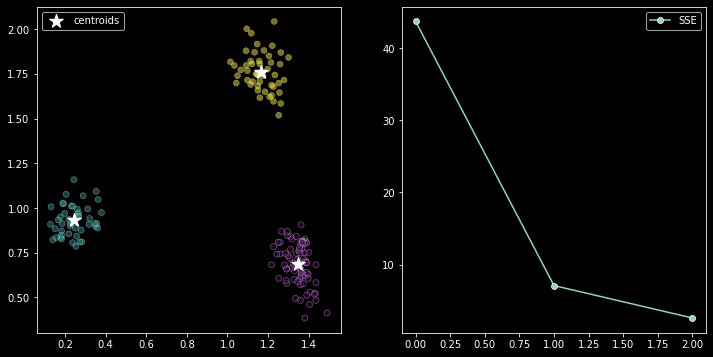

In [866]:
km = Kmeans(k=3, max_iterations=100)
km.fit(data)

#### Calculating K-means and SSE using `K = 2,...,10`

--------------------------------------------------
Number of clusters: 2
Number of centroids: 2
Current iteration: 1
SSE: 39.214655444356836
--------------------------------------------------
--------------------------------------------------
Number of clusters: 2
Number of centroids: 2
Current iteration: 2
SSE: 38.844693834734045
--------------------------------------------------


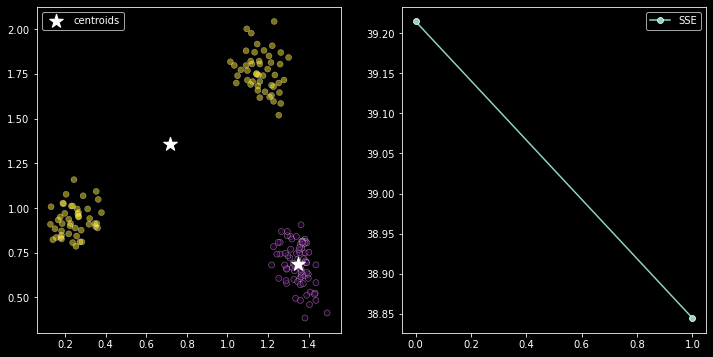

--------------------------------------------------
Number of clusters: 3
Number of centroids: 3
Current iteration: 1
SSE: 26.5541654583494
--------------------------------------------------
--------------------------------------------------
Number of clusters: 3
Number of centroids: 3
Current iteration: 2
SSE: 2.60399663544384
--------------------------------------------------


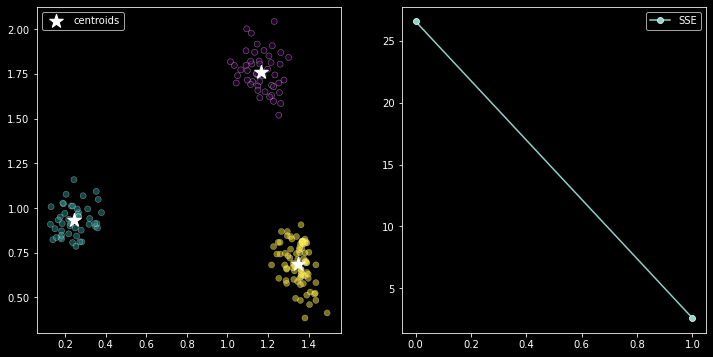

--------------------------------------------------
Number of clusters: 4
Number of centroids: 4
Current iteration: 1
SSE: 16.222009008414584
--------------------------------------------------
--------------------------------------------------
Number of clusters: 4
Number of centroids: 4
Current iteration: 2
SSE: 2.3900554241666665
--------------------------------------------------
--------------------------------------------------
Number of clusters: 4
Number of centroids: 4
Current iteration: 3
SSE: 2.370605965176282
--------------------------------------------------
--------------------------------------------------
Number of clusters: 4
Number of centroids: 4
Current iteration: 4
SSE: 2.368349599915476
--------------------------------------------------
--------------------------------------------------
Number of clusters: 4
Number of centroids: 4
Current iteration: 5
SSE: 2.367532850738636
--------------------------------------------------


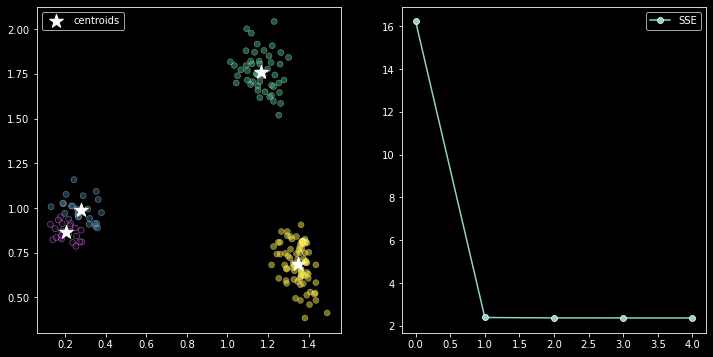

--------------------------------------------------
Number of clusters: 5
Number of centroids: 5
Current iteration: 1
SSE: 1.8352523040767663
--------------------------------------------------
--------------------------------------------------
Number of clusters: 5
Number of centroids: 5
Current iteration: 2
SSE: 1.7630189097056799
--------------------------------------------------
--------------------------------------------------
Number of clusters: 5
Number of centroids: 5
Current iteration: 3
SSE: 1.7148713631757289
--------------------------------------------------
--------------------------------------------------
Number of clusters: 5
Number of centroids: 5
Current iteration: 4
SSE: 1.6983522363831205
--------------------------------------------------
--------------------------------------------------
Number of clusters: 5
Number of centroids: 5
Current iteration: 5
SSE: 1.6834843765172764
--------------------------------------------------
----------------------------------------

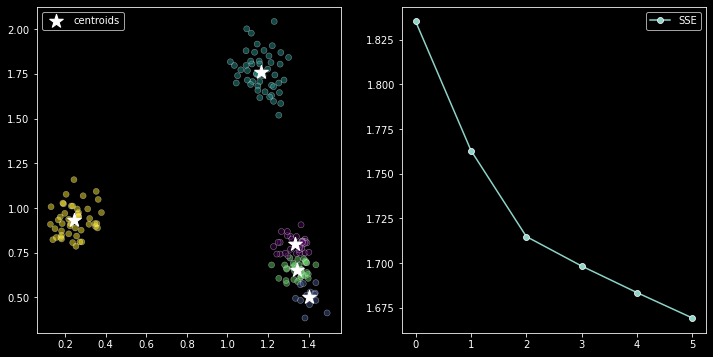

--------------------------------------------------
Number of clusters: 6
Number of centroids: 6
Current iteration: 1
SSE: 10.299454338801937
--------------------------------------------------
--------------------------------------------------
Number of clusters: 6
Number of centroids: 6
Current iteration: 2
SSE: 1.6343728081004607
--------------------------------------------------
--------------------------------------------------
Number of clusters: 6
Number of centroids: 6
Current iteration: 3
SSE: 1.6101448143511092
--------------------------------------------------
--------------------------------------------------
Number of clusters: 6
Number of centroids: 6
Current iteration: 4
SSE: 1.6030758172685156
--------------------------------------------------
--------------------------------------------------
Number of clusters: 6
Number of centroids: 6
Current iteration: 5
SSE: 1.600859630382994
--------------------------------------------------


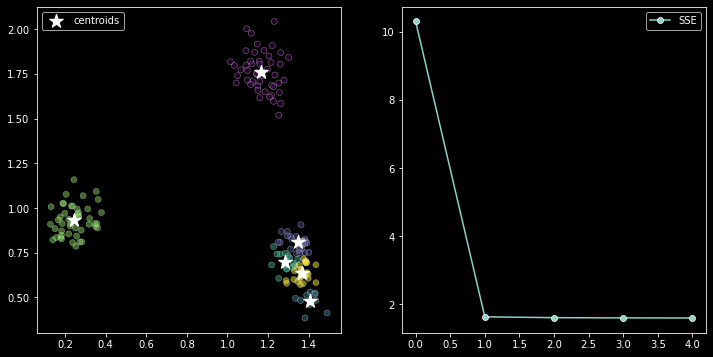

--------------------------------------------------
Number of clusters: 7
Number of centroids: 7
Current iteration: 1
SSE: 1.688271566687143
--------------------------------------------------
--------------------------------------------------
Number of clusters: 7
Number of centroids: 7
Current iteration: 2
SSE: 1.4622235567829316
--------------------------------------------------
--------------------------------------------------
Number of clusters: 7
Number of centroids: 7
Current iteration: 3
SSE: 1.3530773432013707
--------------------------------------------------
--------------------------------------------------
Number of clusters: 7
Number of centroids: 7
Current iteration: 4
SSE: 1.2759684875219537
--------------------------------------------------
--------------------------------------------------
Number of clusters: 7
Number of centroids: 7
Current iteration: 5
SSE: 1.1442701260244252
--------------------------------------------------
-----------------------------------------

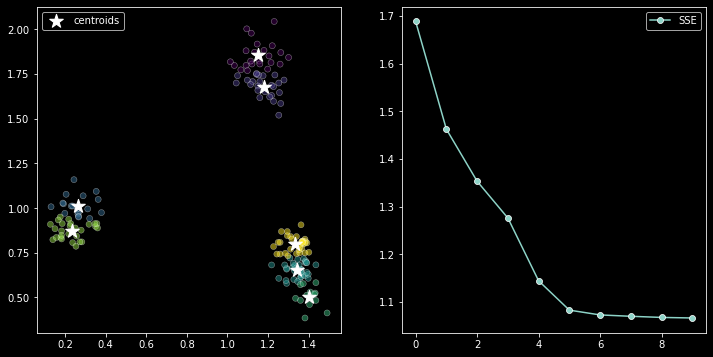

--------------------------------------------------
Number of clusters: 8
Number of centroids: 8
Current iteration: 1
SSE: 1.334093050383649
--------------------------------------------------
--------------------------------------------------
Number of clusters: 8
Number of centroids: 8
Current iteration: 2
SSE: 1.3206017513737511
--------------------------------------------------
--------------------------------------------------
Number of clusters: 8
Number of centroids: 8
Current iteration: 3
SSE: 1.3193024521601509
--------------------------------------------------


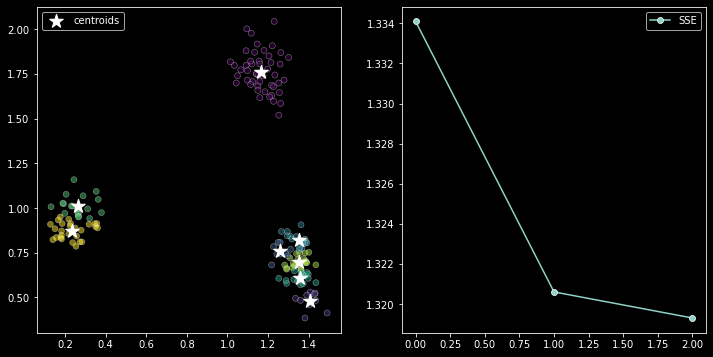

--------------------------------------------------
Number of clusters: 9
Number of centroids: 9
Current iteration: 1
SSE: 1.3507180969615833
--------------------------------------------------
--------------------------------------------------
Number of clusters: 9
Number of centroids: 9
Current iteration: 2
SSE: 1.3031822990757518
--------------------------------------------------
--------------------------------------------------
Number of clusters: 9
Number of centroids: 9
Current iteration: 3
SSE: 1.274327821997222
--------------------------------------------------
--------------------------------------------------
Number of clusters: 9
Number of centroids: 9
Current iteration: 4
SSE: 1.247847432452177
--------------------------------------------------
--------------------------------------------------
Number of clusters: 9
Number of centroids: 9
Current iteration: 5
SSE: 1.2340752475690557
--------------------------------------------------
------------------------------------------

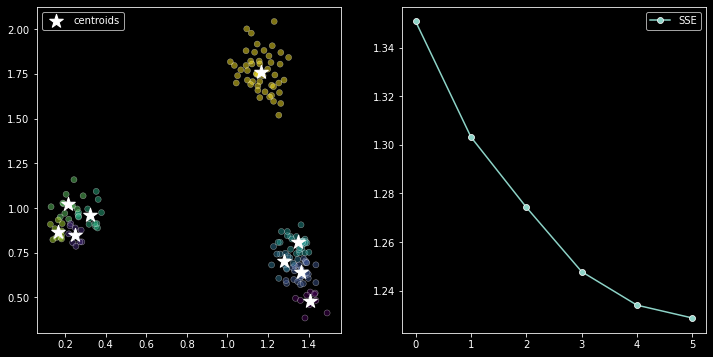

--------------------------------------------------
Number of clusters: 10
Number of centroids: 10
Current iteration: 1
SSE: 0.9842344375380788
--------------------------------------------------
--------------------------------------------------
Number of clusters: 10
Number of centroids: 10
Current iteration: 2
SSE: 0.9175882978413112
--------------------------------------------------
--------------------------------------------------
Number of clusters: 10
Number of centroids: 10
Current iteration: 3
SSE: 0.8781716490248678
--------------------------------------------------
--------------------------------------------------
Number of clusters: 10
Number of centroids: 10
Current iteration: 4
SSE: 0.8613513708894465
--------------------------------------------------
--------------------------------------------------
Number of clusters: 10
Number of centroids: 10
Current iteration: 5
SSE: 0.8563507371752592
--------------------------------------------------
------------------------------

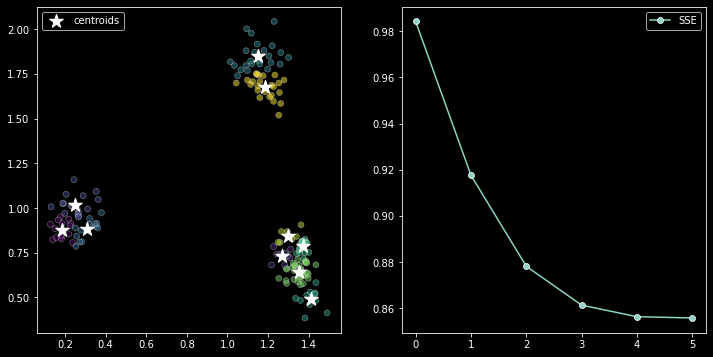

In [867]:
sse_sum = []
k_num = []
for i in range (9):
    km = Kmeans(k=i+2, max_iterations=100)
    km.fit(data)
    sse_sum.append(km.sse[-1])
    k_num.append(i+2)


#### Summed SSE per K

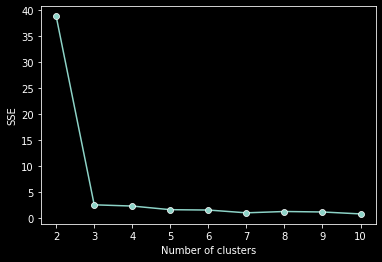

In [868]:
sns.lineplot(x=k_num, y=sse_sum, marker='o')
plt.ylabel('SSE')
plt.xlabel('Number of clusters')
plt.show()

#### Plotting K means and SSE after each iteration

--------------------------------------------------
Number of clusters: 3
Number of centroids: 3
Current iteration: 1
SSE: 57.04922142825845
--------------------------------------------------


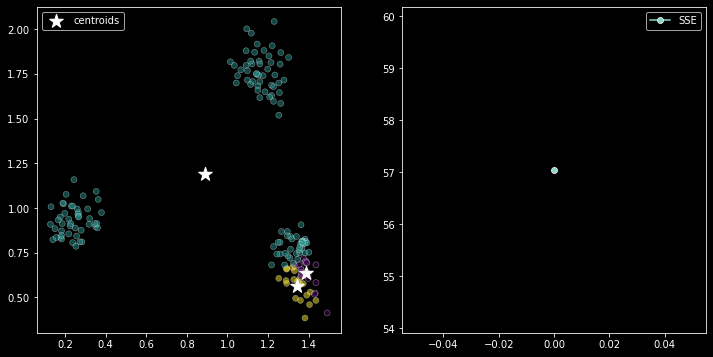

--------------------------------------------------
Number of clusters: 3
Number of centroids: 3
Current iteration: 2
SSE: 38.2781929013559
--------------------------------------------------


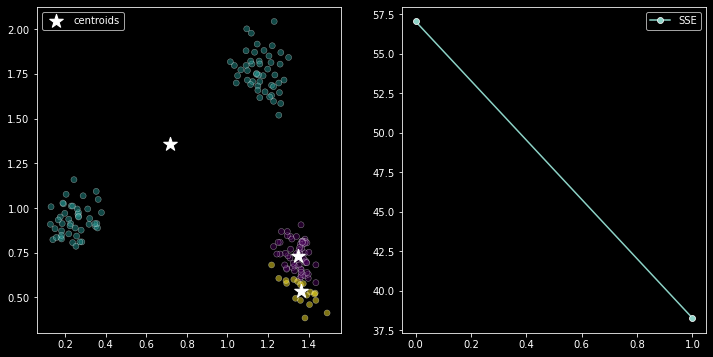

--------------------------------------------------
Number of clusters: 3
Number of centroids: 3
Current iteration: 3
SSE: 38.151154575743135
--------------------------------------------------


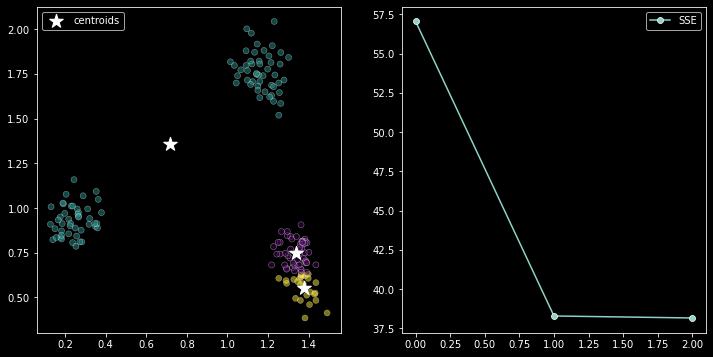

--------------------------------------------------
Number of clusters: 3
Number of centroids: 3
Current iteration: 4
SSE: 38.13651594745767
--------------------------------------------------


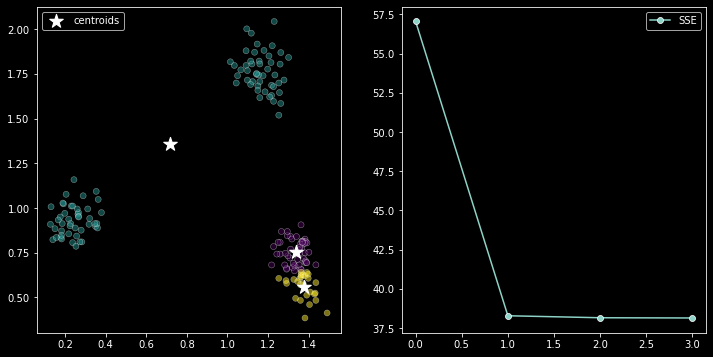

--------------------------------------------------
Number of clusters: 3
Number of centroids: 3
Current iteration: 5
SSE: 38.12868301416738
--------------------------------------------------


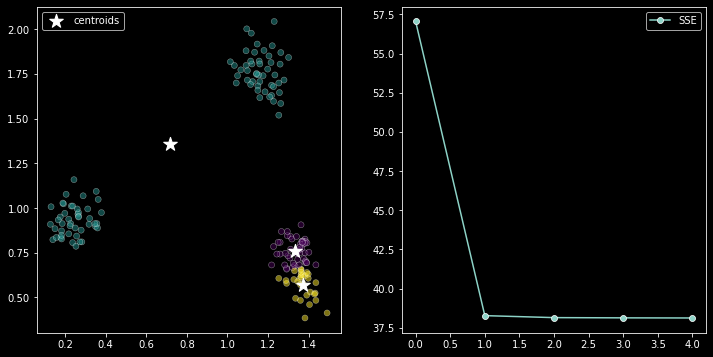

In [869]:
km = Kmeans(k=3, max_iterations=100, log=True)
km.fit(data)